# Layout Optimization for a 3×3 Wind Farm (Greedy Search)


In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.turbine import Turbine
from src.wake_model import velocity_deficit, is_in_wake
from src.utils import plot_farm_layout


In [2]:
# Load turbine specs
data_path = os.path.join(project_root, "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]

U_inf = 8.0
k = 0.04

# Initial 3x3 grid, spacing 5D
spacing = 5 * D

def create_base_farm():
    turbines = []
    for i in range(3):
        for j in range(3):
            x = i * spacing
            y = j * spacing
            turbines.append(Turbine(x, y, D, C_T, P_rated))
    return turbines

base_turbines = create_base_farm()


In [3]:
def effective_speed(t, turbines, U_inf, k):
    deficits = []
    for u in turbines:
        if u is t:
            continue
        if u.x >= t.x:
            continue
        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            dU = velocity_deficit(dx, U_inf, u.C_T, u.R, k) * U_inf
            deficits.append(dU)
    if not deficits:
        return U_inf
    return max(U_inf - np.sqrt(np.sum(np.array(deficits)**2)), 0.0)


def farm_power(turbines, U_inf=8.0, k=0.04):
    total = 0.0
    for t in turbines:
        U_eff = effective_speed(t, turbines, U_inf, k)
        P = min(P_rated, P_rated * (U_eff / U_inf)**3)
        total += P
    return total


In [4]:
rng = np.random.default_rng(42)

# Bounds for movement (keep farm roughly in same area)
X_MIN, X_MAX = -D, 2 * spacing + D
Y_MIN, Y_MAX = -D, 2 * spacing + D

def perturb_turbine(t, step):
    x_new = np.clip(t.x + rng.uniform(-step, step), X_MIN, X_MAX)
    y_new = np.clip(t.y + rng.uniform(-step, step), Y_MIN, Y_MAX)
    return Turbine(x_new, y_new, t.D, t.C_T, t.rated_power_kw)


def greedy_optimize(turbines, iterations=200, step=D):
    current = [Turbine(t.x, t.y, t.D, t.C_T, t.rated_power_kw) for t in turbines]
    best_power = farm_power(current, U_inf, k)
    history = [best_power]

    for it in range(iterations):
        # pick a random turbine to move
        idx = rng.integers(0, len(current))
        candidate = [Turbine(t.x, t.y, t.D, t.C_T, t.rated_power_kw) for t in current]
        candidate[idx] = perturb_turbine(candidate[idx], step)

        P_new = farm_power(candidate, U_inf, k)
        if P_new > best_power:
            current = candidate
            best_power = P_new
        history.append(best_power)

    return current, history


In [5]:
initial_power = farm_power(base_turbines, U_inf, k)
optimized_turbines, power_history = greedy_optimize(base_turbines, iterations=300, step=0.5*D)
optimized_power = farm_power(optimized_turbines, U_inf, k)

initial_power, optimized_power


(np.float64(15042.272173917632), np.float64(25882.359645912784))

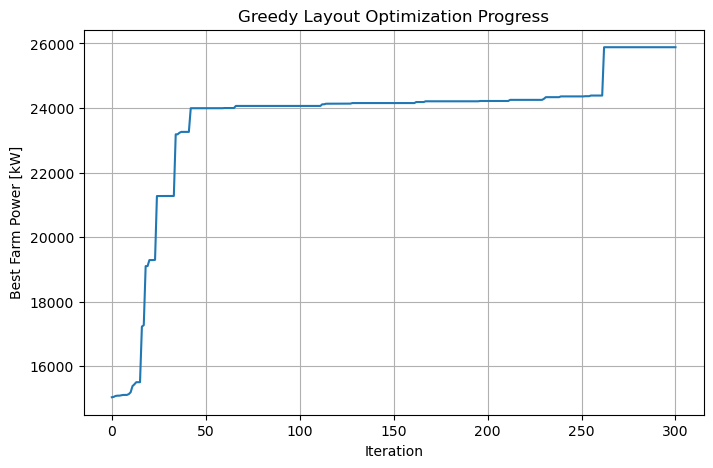

In [6]:
plt.figure(figsize=(8,5))
plt.plot(power_history)
plt.xlabel("Iteration")
plt.ylabel("Best Farm Power [kW]")
plt.title("Greedy Layout Optimization Progress")
plt.grid(True)

results_dir = os.path.join(project_root, "results")
os.makedirs(results_dir, exist_ok=True)

plt.savefig(os.path.join(results_dir, "optimization_progress.png"),
            dpi=300, bbox_inches="tight")
plt.show()


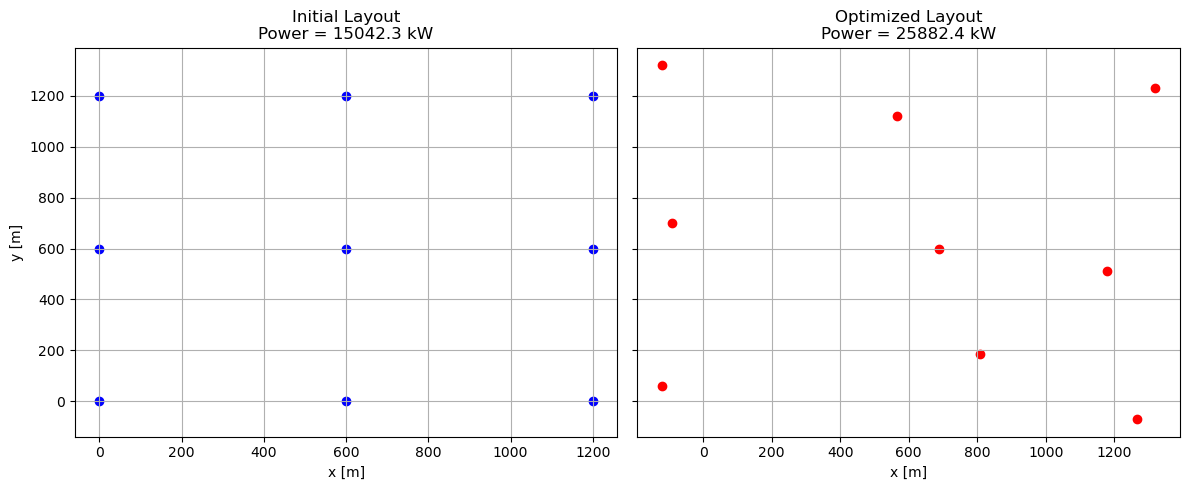

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# Initial
ax = axes[0]
xs0 = [t.x for t in base_turbines]
ys0 = [t.y for t in base_turbines]
ax.scatter(xs0, ys0, c="blue")
ax.set_title(f"Initial Layout\nPower = {initial_power:.1f} kW")
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.grid(True)

# Optimized
ax = axes[1]
xs1 = [t.x for t in optimized_turbines]
ys1 = [t.y for t in optimized_turbines]
ax.scatter(xs1, ys1, c="red")
ax.set_title(f"Optimized Layout\nPower = {optimized_power:.1f} kW")
ax.set_xlabel("x [m]")
ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, "optimized_layout.png"),
            dpi=300, bbox_inches="tight")
plt.show()


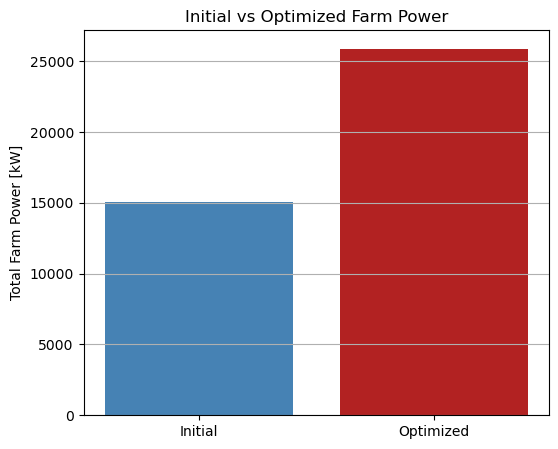

In [8]:
plt.figure(figsize=(6,5))
plt.bar(["Initial", "Optimized"], [initial_power, optimized_power],
        color=["steelblue", "firebrick"])

plt.ylabel("Total Farm Power [kW]")
plt.title("Initial vs Optimized Farm Power")
plt.grid(axis="y")

plt.savefig(os.path.join(results_dir, "initial_vs_optimized_power.png"),
            dpi=300, bbox_inches="tight")
plt.show()
